In [1]:
from itertools import chain
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from matplotlib import cm
from neuron import h
import json
import pickle
from dlutils import utils
from dlutils.cell import Cell
from dlutils.synapse import AMPAExp2Synapse, NMDAExp2Synapse
from dlutils.spine import Spine
%matplotlib inline

> /Users/daniele/local/lib/python3.7/site-packages/neuron/__init__.py(105)<module>()
-> import sys
(Pdb) c


### General parameters

In [2]:
cell_type = 'a-thorny'
optimization_folder = '/Users/daniele/Postdoc/Research/Janelia/01_model_optimization/'

if cell_type == 'thorny':
    base_folder = optimization_folder + 'Thorny/DH070813/20191208071008_DH070813_/'
    swc_file = 'DH070813-.Edit.scaled.converted.swc'
    cell_name = 'DH070813_'
    individual = 1
else:
    base_folder = optimization_folder + 'A-thorny/DH070213C3/20191206232623_DH070213C3_/'
    swc_file = 'DH070213C3-.Edit.scaled.converted.swc'
    cell_name = 'DH070213C3_'
    individual = 0
    
swc_file = base_folder + swc_file
params_file = base_folder + 'individual_{}.json'.format(individual)
config_file = base_folder + 'parameters.json'

passive = False
with_TTX = True
replace_axon = True
add_axon_if_missing = True
parameters = json.load(open(params_file, 'r'))
mechanisms = utils.extract_mechanisms(config_file, cell_name)
sim_pars = pickle.load(open(base_folder + 'simulation_parameters.pkl','rb'))
replace_axon = sim_pars['replace_axon']
add_axon_if_missing = not sim_pars['no_add_axon']

### Instantiate the cell

In [3]:
cell = Cell('CA3_cell_%d' % int(np.random.uniform()*1e5), swc_file, parameters, mechanisms)
cell.instantiate(replace_axon, add_axon_if_missing, force_passive=passive, TTX=with_TTX)
if cell_type == 'thorny':
    section_num = 7
else:
    section_num = 11

section = cell.morpho.apic[section_num]
# Ra = 150
Ra = section.Ra

One point section Import3d_Section[2] ending at line 3 has been removed
One point section Import3d_Section[1] ending at line 2 has been removed


### Instantiate the spines

In [4]:
# in the Harnett paper, the head is spherical with a diameter of 0.5 um: a cylinder
# with diameter and length equal to 0.5 has the same (outer) surface area as the sphere
head_L = 0.5
head_diam = 0.5
neck_L = 1.58
neck_diam = 0.077
n_spines = 10
delta = 0.05 * (n_spines - 1) / 2
spines = [Spine(section, x, head_L, head_diam, neck_L, neck_diam, Ra, i) \
          for i,x in enumerate(np.linspace(0.5 - delta, 0.5 + delta, n_spines))]
for spine in spines:
    spine.instantiate()

Spine axial resistivity: 341.46 Ohm cm.
Spine axial resistivity: 341.46 Ohm cm.
Spine axial resistivity: 341.46 Ohm cm.
Spine axial resistivity: 341.46 Ohm cm.
Spine axial resistivity: 341.46 Ohm cm.
Spine axial resistivity: 341.46 Ohm cm.
Spine axial resistivity: 341.46 Ohm cm.
Spine axial resistivity: 341.46 Ohm cm.
Spine axial resistivity: 341.46 Ohm cm.
Spine axial resistivity: 341.46 Ohm cm.


#### Show where the spines are located on the dendritic tree

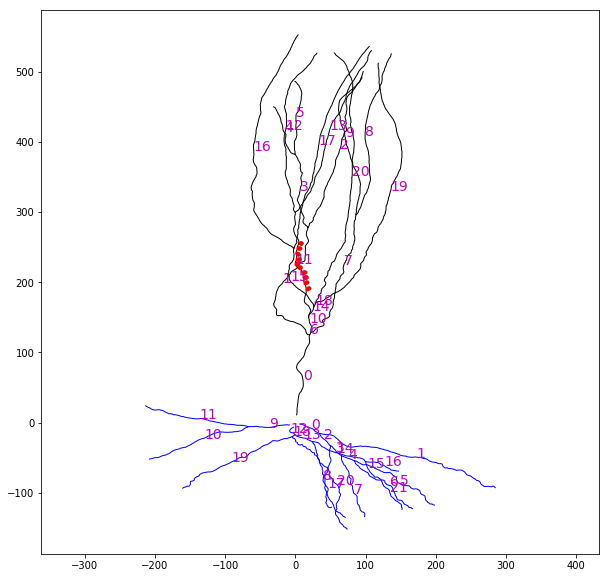

In [5]:
plt.figure(figsize=(10,10))
for sec in chain(cell.morpho.apic, cell.morpho.basal):
    if sec in cell.morpho.apic:
        color = 'k'
    else:
        color = 'b'
    lbl = sec.name().split('.')[1].split('[')[1][:-1]
    n = sec.n3d()
    sec_coords = np.zeros((n,2))
    for i in range(n):
        sec_coords[i,:] = np.array([sec.x3d(i), sec.y3d(i)])
    middle = int(n / 2)
    plt.text(sec_coords[middle,0], sec_coords[middle,1], lbl, \
             fontsize=14, color='m')
    plt.plot(sec_coords[:,0], sec_coords[:,1], color, lw=1)
for spine in spines:
    plt.plot(spine._points[:,0], spine._points[:,1], 'r.')
# plt.axis([-100,0,0,200])
plt.axis('equal');

### Insert a synapse into each spine

In [6]:
E = 0        # [mV]
tau_rise  = {'AMPA': 0.1, 'NMDA': 1.0}
tau_decay = {'AMPA': 1.0, 'NMDA': 20.0}

if cell_type == 'thorny':
    weights = {'AMPA': 0.001 + 0*0.0002 * np.random.uniform(size=n_spines),
               'NMDA': 0.001 + 0*0.0002 * np.random.uniform(size=n_spines)}
else:
    weights = {'AMPA': 0.002 + 0*0.0002 * np.random.uniform(size=n_spines),
               'NMDA': 0.002 + 0*0.0002 * np.random.uniform(size=n_spines)}

synapses = {'AMPA': [AMPAExp2Synapse(spine.head, 1, E, tau_rise['AMPA'], tau_decay['AMPA'], weight) \
                     for spine, weight in zip(spines, weights['AMPA'])],
            'NMDA': [AMPAExp2Synapse(spine.head, 1, E, tau_rise['NMDA'], tau_decay['NMDA'], weight) \
                     for spine, weight in zip(spines, weights['NMDA'])]}

#### Compute the presynaptic spike times

In [7]:
t0 = 1000.
dt = 1000.
spike_times = [np.sort(t0 + (n_spines - 1) * dt - np.arange(i) * dt) for i in range(n_spines, 0, -1)]
poisson = True
if poisson:
    # frequency of the incoming spikes
    F = 10
    for i in range(n_spines):
        ISI = - np.log(np.random.uniform(size=n_spines*2)) / F
        spks = np.cumsum(ISI)
        for j in range(n_spines - i):
            spike_times[j][i] += spks[j]
for ampa_syn, nmda_syn, spks in zip(synapses['AMPA'], synapses['NMDA'], spike_times):
    ampa_syn.set_presynaptic_spike_times(spks)
    nmda_syn.set_presynaptic_spike_times(spks)

In [8]:
spike_times

[array([ 1000.01694176,  2000.06205281,  3000.18882696,  4000.04394507,
         5000.17262942,  6000.04381662,  7000.03459768,  8000.03080857,
         9000.00130992, 10000.12219792]),
 array([ 2000.11991648,  3000.08134971,  4000.19638646,  5000.10588734,
         6000.2269553 ,  7000.06503986,  8000.22565843,  9000.04680409,
        10000.23563638]),
 array([ 3000.14176624,  4000.1879123 ,  5000.2462641 ,  6000.35546923,
         7000.42769735,  8000.11890495,  9000.2426382 , 10000.07496351]),
 array([ 4000.17261954,  5000.20176886,  6000.49428055,  7000.54678916,
         8000.51149107,  9000.30144614, 10000.42892847]),
 array([ 5000.25744356,  6000.31216261,  7000.56225936,  8000.66368864,
         9000.60155076, 10000.36364489]),
 array([ 6000.42697065,  7000.31985513,  8000.57971404,  9000.68385642,
        10000.91195399]),
 array([ 7000.51954888,  8000.35207441,  9000.67332477, 10000.72354331]),
 array([ 8000.73269447,  9000.36770206, 10000.67730699]),
 array([ 9000.92950742, 

In [9]:
rec = {}
for lbl in 't','Vsoma':
    rec[lbl] = h.Vector()
rec['t'].record(h._ref_t)
rec['Vsoma'].record(cell.morpho.soma[0](0.5)._ref_v)
for i,spine in enumerate(spines):
    rec['Vapic-{}'.format(i)] = h.Vector()
    rec['Vhead-{}'.format(i)] = h.Vector()
    rec['Vapic-{}'.format(i)].record(sec(spine._sec_x)._ref_v)
    rec['Vhead-{}'.format(i)].record(spine.head(0.5)._ref_v)

h.cvode_active(1)
h.tstop = t0 + n_spines * dt
h.run()

0.0

Text(0, 0.5, 'Somatic voltage (mV)')

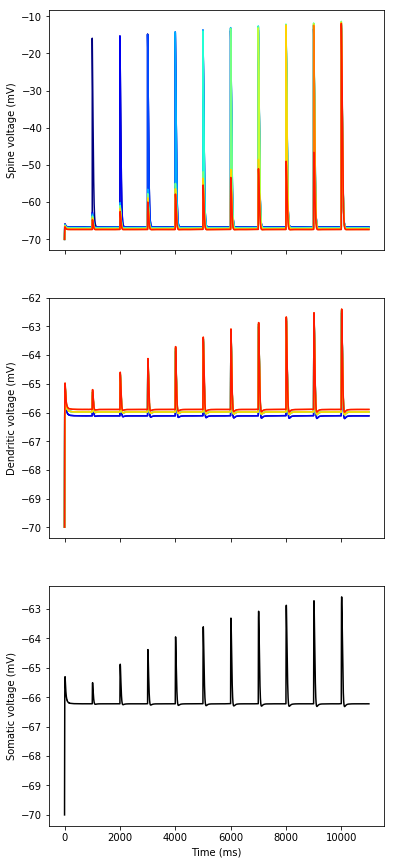

In [10]:
fig,ax = plt.subplots(3, 1, figsize=(6,15), sharex=True)

# xlim = [470,np.max(spike_times)+150]
xlim = [0,h.tstop]

t = np.array(rec['t'])
idx, = np.where((t > xlim[0]) & (t < xlim[1]))
step = int(np.floor(256 / n_spines))
for i in range(n_spines):
    col = cm.jet(i*step)
    vhead = np.array(rec['Vhead-{}'.format(i)])
    vdend = np.array(rec['Vapic-{}'.format(i)])
    ax[0].plot(t[idx], vhead[idx], color=col, label='Spine #{}'.format(i+1))
#     ax[0].plot(spike_times[i] + np.zeros(2), [-68,-66], color=col, lw=2)
    ax[1].plot(t[idx], vdend[idx], color=col, label='Spine #{}'.format(i+1))
#     ax[1].plot(spike_times[i] + np.zeros(2), [-68,-66], color=col, lw=2)
#ax[1].plot(rec['t'], rec['Vsoma'], 'k', label='Soma')
vsoma = np.array(rec['Vsoma'])
ax[2].plot(t[idx], vsoma[idx], 'k', label='Soma')

ax[2].set_xlabel('Time (ms)')
ax[0].set_ylabel('Spine voltage (mV)')
ax[1].set_ylabel('Dendritic voltage (mV)')
ax[2].set_ylabel('Somatic voltage (mV)')
# ax1.legend(loc='best')
# ax2.legend(loc='best')
# ax[0].set_xlim()
#ax[0].set_xlim([500,520])

In [22]:
idx, = np.where(t > t0*0.95)
x = vsoma[idx]
pks,_ = find_peaks(x, height=vsoma[-1]+0.5, distance=200)
dV = x[pks] - vsoma[-1]
# pks += idx[-1]
# len(pks)

Text(0, 0.5, 'Somatic EPSP (mV)')

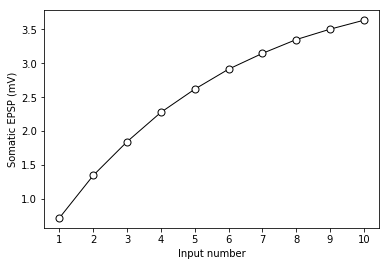

In [23]:
plt.plot(1 + np.arange(n_spines), dV, 'ko-', markerfacecolor='w', markersize=7, linewidth=1)
plt.xticks(1 + np.arange(n_spines))
plt.xlabel('Input number')
plt.ylabel('Somatic EPSP (mV)')